# Lab 9: Variational Autoencoders

นาย นันท์มนัส ตั้งประเสริฐ, 63070501040<br>
นาย สัณหณัฐ พรมจรรย์, 63070501069<br>

![alt text](https://hackernoon.com/hn-images/1*op0VO_QK4vMtCnXtmigDhA.png)





## Lab Instruction: Generate Random Handwriting Number

In this lab, you will learn do the generative model using variational autoencoder to generate random image.</br>

This is what we are going to do in this lab: https://www.siarez.com/projects/variational-autoencoder </br>
About the variational autoencoder: https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

This lab, we created model using functional API > https://keras.io/models/model/

### Autoencoder Model

![alt text](https://blog.keras.io/img/ae/autoencoder_schema.jpg)


***Images from:<br>***
*1. <a href=https://blog.keras.io/building-autoencoders-in-keras.html> Keras Blog </a></br>*
*2. Manning - Deep Learning with Python Book*


In [1]:
# Import required libraries
import keras
from keras import models
from keras import layers
from keras import backend as K
from keras import callbacks
from keras.losses import mse

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from sklearn.model_selection import train_test_split

%matplotlib inline

### Load MNIST data

In [2]:
# Load MNIST data
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# Data exploration: Shape
x_train.shape

(60000, 28, 28)

In [4]:
# Data exploration: Data type
x_train.dtype

dtype('uint8')

In [5]:
# Min, Max value
np.min(x_train),np.max(x_train)

(0, 255)

### Preprocess data

In [6]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_train = x_train/255.

x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)
x_test = x_test/255.

In [7]:
# shape after preprocess
x_train.shape

(60000, 28, 28, 1)

### Split Train, Test, Validation data

In [8]:
# Split data
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,
                                                  test_size=0.1,
                                                  stratify=y_train,
                                                  random_state=0)

### Create variational autoencoder model

In technical terms, here’s how a VAE works:
1. An encoder module turns the input samples input_img into two parameters in a latent space of representations, z_mean and z_log_variance.
2. You randomly sample a point z from the latent normal distribution that’s assumed to generate the input image, via
> z= z_mean+exp(z_log_variance)* epsilon, *where epsilon is a random tensor of small values.*
3. A decoder module maps this point in the latent space back to the original input image.

In [9]:
# Define variables
input_shape=(28,28,1)
batch_size=16
latent_dim=2 # 2 latent vector to represent MNIST data

In [10]:
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Conv2D, Flatten, Reshape, Conv2DTranspose,BatchNormalization,LeakyReLU,Dropout

In [11]:
# Encoder Model
inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)

In [ ]:
x = Conv2D(32, 3, activation ="relu", strides = 2, padding ="same")(encoder_inputs)
x = Conv2D(64, 3, activation ="relu", strides = 2, padding ="same")(x)
x = Flatten()(x)
x = Dense(16, activation ="relu")(x

In [12]:
# Variation Parameters
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [13]:
# Sampling distribution funtion
def sampling(arg):
    z_mean, z_log_var = arg
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

In [14]:
# Distribution function sampling layer
z = layers.Lambda(sampling)([z_mean, z_log_var])

In [15]:
# Wrap up encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

To define a deconvolution layer
> ```layers.Conv2DTranspose( )```

See: https://keras.io/layers/convolutional/ Search for ```Conv2DTranspose```

In [16]:
# Decoder model
decoder_input = Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', )(x)
x = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', )(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [17]:
# Wrap up decoder model
decoder = Model(decoder_input, x, name='decoder')

In [31]:
# Warp up VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

The parameters of a VAE are trained via two loss functions:
1. A reconstruction loss that forces the decoded samples to match the initial inputs.
2. A regularization loss (The Kullback-Liebler divergence) that helps learn well-formed latent spaces and reduce overfitting to the training data.

In [25]:
# # Create custom loss function
# def vae_loss(x, x_decoded_mean):
#     xent_loss = K.binary_crossentropy(x, x_decoded_mean)
#     kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#     return xent_loss + kl_loss

In [32]:
# Create custom loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

### Compile and Summarise Model

In [33]:
# Compile and summarise model
vae.compile(optimizer='adam')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  142852    ['input_1[0][0]']             
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 28, 28, 1)            87553     ['encoder[3][2]']             
                                                                                                

In [28]:
# Plot training history
def viz_loss(history):

    # Print the result from the last epoch
    print('Last Training set loss: %s'%history.history['loss'][-1])
    print('Last Validation set loss: %s'%history.history['val_loss'][-1])

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'c--', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

### Training The VAE Model

In [23]:
# Define callback for checkpoint
checkpoint = callbacks.ModelCheckpoint(filepath='/model_checkpoint.h5', verbose=1, save_best_only=True)
#xxxxxxxxx make file path to keep logs

In [24]:
# Define callback for Tensorboard
tensorboard = callbacks.TensorBoard(log_dir='/model')
#in xxxxxxxxx path make logs folder to keeps log

To call a Tensorboard, open terminal and type
>``` tensorboard --logdir=/full_path_to_your_logs ```

In [ ]:
!tensorboard --logdir="/model"

In [34]:
# Train model
his = vae.fit(x_train, x_train, epochs=10,
              batch_size=batch_size, validation_data=(x_val, x_val))

Epoch 1/10
3375/3375 [==============================] - 440s 130ms/step - loss: 43.8719 - val_loss: 41.1808
Epoch 2/10
3375/3375 [==============================] - 417s 124ms/step - loss: 39.6397 - val_loss: 38.9789
Epoch 3/10
3375/3375 [==============================] - 407s 120ms/step - loss: 38.5960 - val_loss: 38.1629
Epoch 4/10
3375/3375 [==============================] - 406s 120ms/step - loss: 38.0525 - val_loss: 37.7962
Epoch 5/10
3375/3375 [==============================] - 406s 120ms/step - loss: 37.6953 - val_loss: 38.3208
Epoch 6/10
3375/3375 [==============================] - 406s 120ms/step - loss: 37.4479 - val_loss: 37.3485
Epoch 7/10
3375/3375 [==============================] - 406s 120ms/step - loss: 37.2181 - val_loss: 37.2169
Epoch 8/10
3375/3375 [==============================] - 411s 122ms/step - loss: 37.0433 - val_loss: 36.9243
Epoch 9/10
3375/3375 [==============================] - 406s 120ms/step - loss: 36.8890 - val_loss: 36.9107
Epoch 10/10
3375/3375 [=====

Last Training set loss: 36.75598907470703
Last Validation set loss: 36.77474594116211


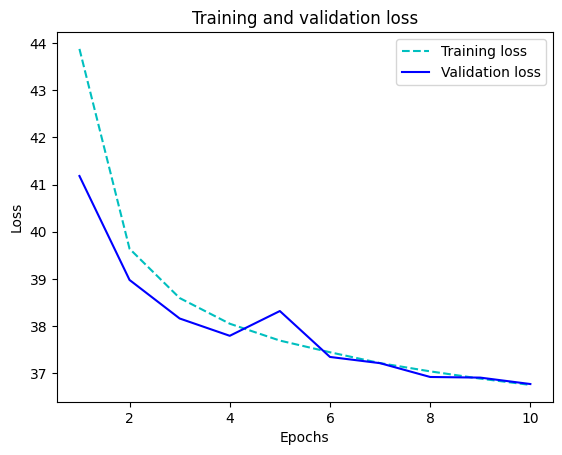

In [35]:
# Visualize loss
viz_loss(his)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir = '/model'

### Predicting on Test Datast

In [36]:
# Reconstruct image using test dataset
def visualize_image(image, row=3, col=10, title='Generated hadwriting digit image'):
    fig, ax = plt.subplots(row,col,figsize=(13,4))
    fig.suptitle(title)
    for i in range(row):
        for j in range(col):
            ax[i,j].imshow(image[j + i*10],cmap='gray')
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)

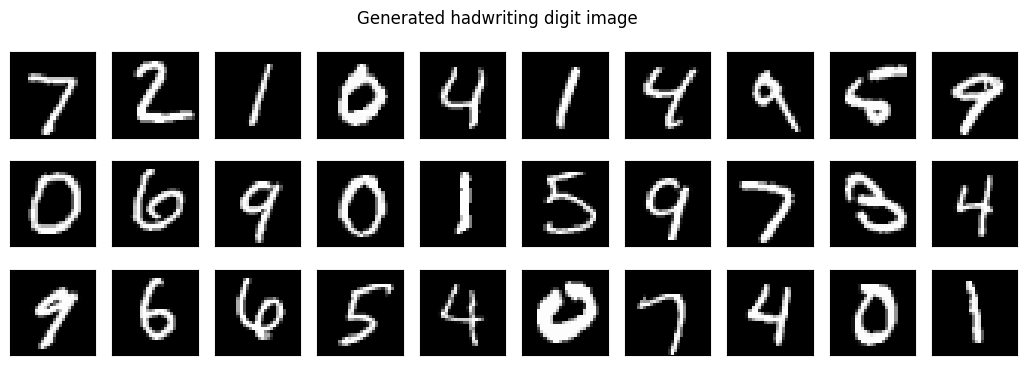

In [56]:
# Show test image
x_test_reshape = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2])
visualize_image(x_test_reshape)

313/313 [==============================] - 17s 52ms/step


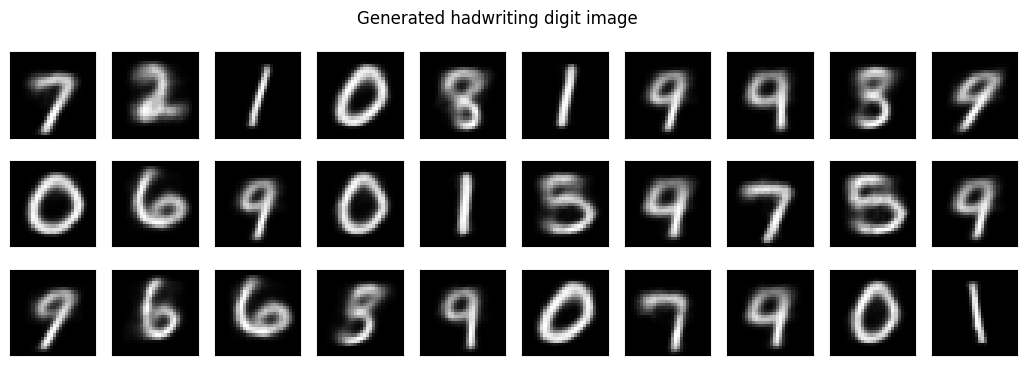

In [38]:
# Show reconstruct image
decoded_imgs = vae.predict(x_test)
decoded_imgs = decoded_imgs.reshape(decoded_imgs.shape[0],decoded_imgs.shape[1],decoded_imgs.shape[2])
visualize_image(decoded_imgs)

### Try Randomly Generate Data

In [39]:
# Randomly generate a latent vector
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

random_input = np.random.uniform(high=2,low=-2,size=(64,latent_dim))

In [64]:
# Reconstruct image
x_decoded = decoder.predict(random_input, batch_size=batch_size)

4/4 [==============================] - 0s 19ms/step


In [65]:
# Exploration: X_decode's shape
print(f"Shape of x_decoded: {x_decoded.shape}")

Shape of x_decoded: (64, 28, 28, 1)


In [66]:
# Reshape x_decode
decode_digit = x_decoded.reshape(64,digit_size, digit_size)

### Show Generated Image

In [67]:
# Define visualized image function
def visualize_image(image, row=3, col=10, title='Generated hadwriting digit image'):
    fig, ax = plt.subplots(row,col,figsize=(13,4))
    fig.suptitle(title)
    for i in range(row):
        for j in range(col):
            ax[i,j].imshow(image[j + i*10],cmap='gray')
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)

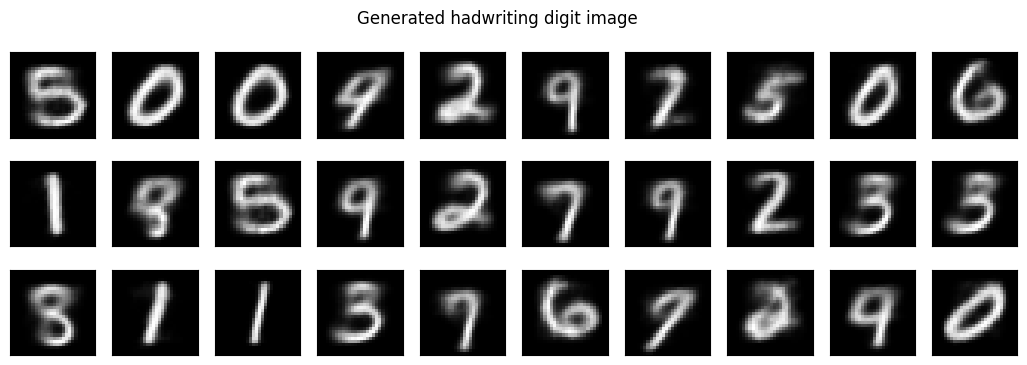

In [68]:
# Show reconstruct image
visualize_image(decode_digit)

### Scan The Latent Space

In [ ]:
# Display a 2D manifold of the digits

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 5e-4
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

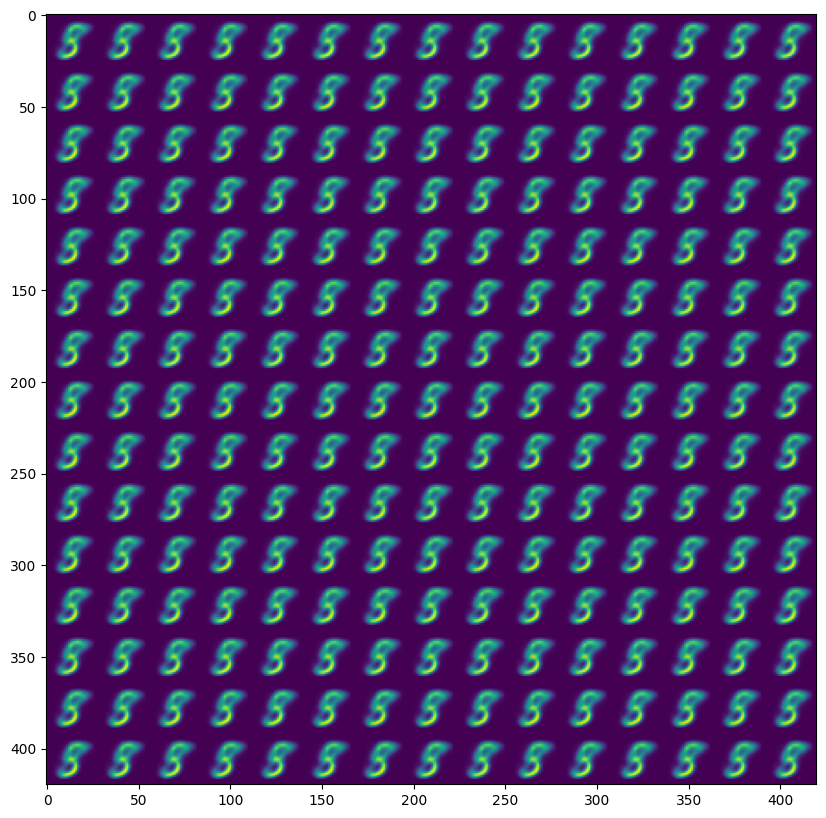

In [102]:
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

### Visualize Latent Space

The colored clusters is a type of digit. Close clusters are digits that are structurally similar (i.e. digits that share information in the latent space).

In [79]:
# Estimate latent space from test set
x_encoded, _, _ = encoder.predict(x_test, batch_size=batch_size)

625/625 [==============================] - 7s 11ms/step


In [73]:
# Define latent space visualizatio function

def show_latent_space(encoded_imgs, y_test):
    plt.figure(figsize=(10, 8))
    plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1],
                c=y_test,alpha=.7, s=3**2, cmap='viridis')
    plt.colorbar()
    plt.show()

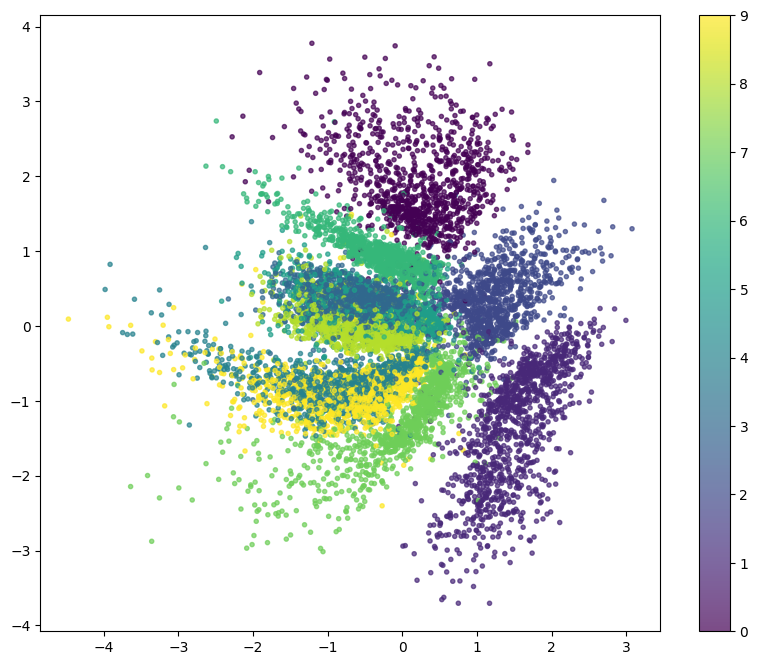

In [80]:
# Show latent space
show_latent_space(x_encoded, y_test)

### Another design

In [91]:
# Define variables
input_shape=(28,28,1)
batch_size_0=128
latent_dim=2 # 2 latent vector to represent MNIST data

# Encoder Model
inputs_0 = Input(shape=input_shape)
x_0 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs_0)
x_0 = Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding='same')(x_0)
x_0= Flatten()(x_0)

# Variation Parameters
z_mean_0 = Dense(latent_dim)(x_0)
z_log_var_0 = Dense(latent_dim)(x_0)

# Distribution function sampling layer
z_0 = layers.Lambda(sampling)([z_mean_0, z_log_var_0])

# Wrap up encoder model
encoder_0 = Model(inputs_0, [z_mean_0, z_log_var_0, z_0], name='encoder')

In [87]:
# Decoder model
decoder_input_0 = Input(K.int_shape(z)[1:])
x_0 = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input_0)
x_0= Reshape(shape_before_flattening[1:])(x_0)
x_0 = Conv2DTranspose(64, (2, 2), activation='relu', padding='same', strides=(2, 2))(x_0)
x_0 = Conv2DTranspose(32, (2, 2), activation='relu', padding='same', )(x_0)
x_0= Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x_0)

# Wrap up decoder model
decoder_0 = Model(decoder_input_0, x_0, name='decoder')

In [88]:
# Warp up VAE model
outputs_0 = decoder_0(encoder_0(inputs_0)[2])
vae_0 = Model(inputs_0, outputs_0, name='vae')

In [89]:
# Create custom loss function
reconstruction_loss = mse(K.flatten(inputs_0), K.flatten(outputs_0))
reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
kl_loss = -0.5 * K.sum(1 + z_log_var_0 - K.square(z_mean_0) - K.exp(z_log_var_0), axis=1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_0.add_loss(vae_loss)

In [90]:
# Compile and summarise model
vae_0.compile(optimizer='adam')
vae_0.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  68996     ['input_7[0][0]']             
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 28, 28, 1)            62593     ['encoder[0][2]']             
                                                                                                

In [92]:
# Train model
his_0 = vae_0.fit(x_train, x_train, epochs=10,
              batch_size=batch_size_0, validation_data=(x_val, x_val))

Epoch 1/10
422/422 [==============================] - 145s 341ms/step - loss: 52.7568 - val_loss: 45.6403
Epoch 2/10
422/422 [==============================] - 140s 332ms/step - loss: 44.6110 - val_loss: 44.1460
Epoch 3/10
422/422 [==============================] - 138s 327ms/step - loss: 42.6103 - val_loss: 41.6140
Epoch 4/10
422/422 [==============================] - 143s 338ms/step - loss: 40.9767 - val_loss: 40.6553
Epoch 5/10
422/422 [==============================] - 139s 328ms/step - loss: 40.2676 - val_loss: 40.0712
Epoch 6/10
422/422 [==============================] - 138s 328ms/step - loss: 39.7937 - val_loss: 39.7691
Epoch 7/10
422/422 [==============================] - 137s 324ms/step - loss: 39.4674 - val_loss: 39.4778
Epoch 8/10
422/422 [==============================] - 135s 319ms/step - loss: 39.2311 - val_loss: 39.3111
Epoch 9/10
422/422 [==============================] - 139s 330ms/step - loss: 39.0495 - val_loss: 39.0354
Epoch 10/10
422/422 [=========================

Last Training set loss: 38.87057876586914
Last Validation set loss: 39.0817756652832


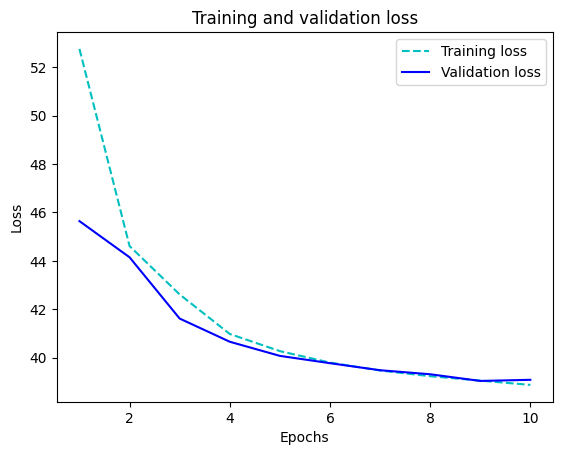

In [93]:
# Visualize loss
viz_loss(his_0)

313/313 [==============================] - 7s 20ms/step


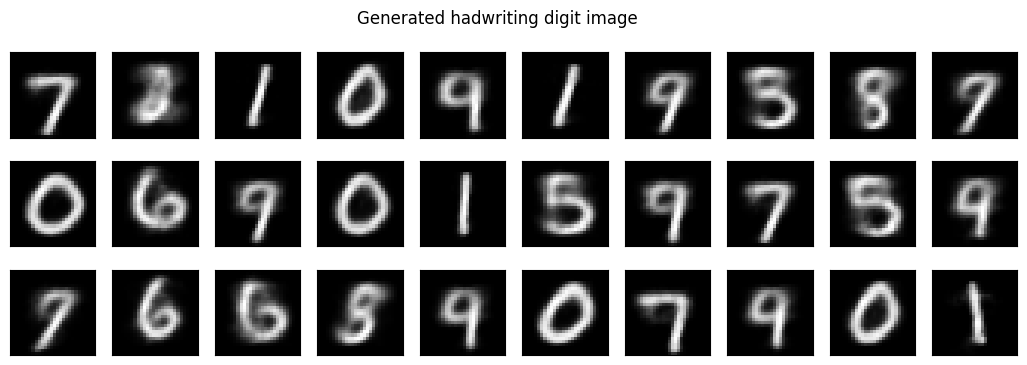

In [100]:
# Show reconstruct image
decoded_imgs_0 = vae_0.predict(x_test)
decoded_imgs_0 = decoded_imgs_0.reshape(decoded_imgs_0.shape[0],decoded_imgs_0.shape[1],decoded_imgs_0.shape[2])
visualize_image(decoded_imgs_0)

In [95]:
# Reconstruct image
x_decoded_0 = decoder_0.predict(random_input, batch_size=batch_size_0)

# Exploration: X_decode's shape
print(f"Shape of x_decoded: {x_decoded_0.shape}")

# Reshape x_decode
decode_digit_0 = x_decoded_0.reshape(64,digit_size, digit_size)

1/1 [==============================] - 0s 92ms/step
Shape of x_decoded: (64, 28, 28, 1)


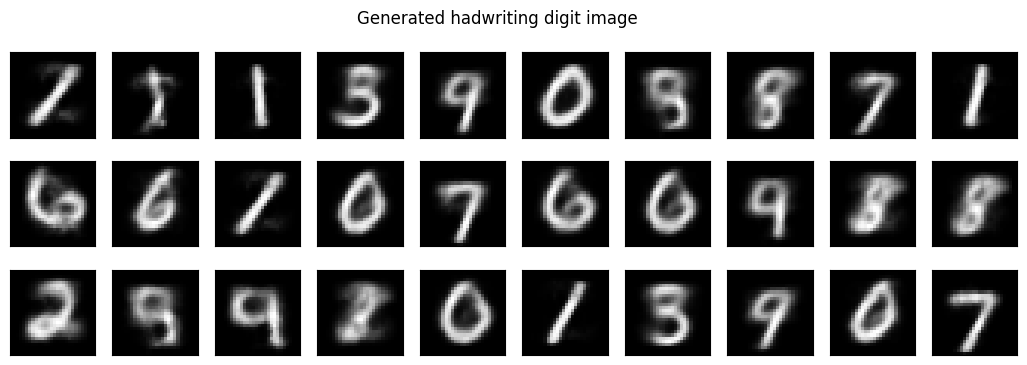

In [96]:
# Show reconstruct image
visualize_image(decode_digit_0)

In [ ]:
# Display a 2D manifold of the digits

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 5e-4
        x_decoded = decoder_0.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

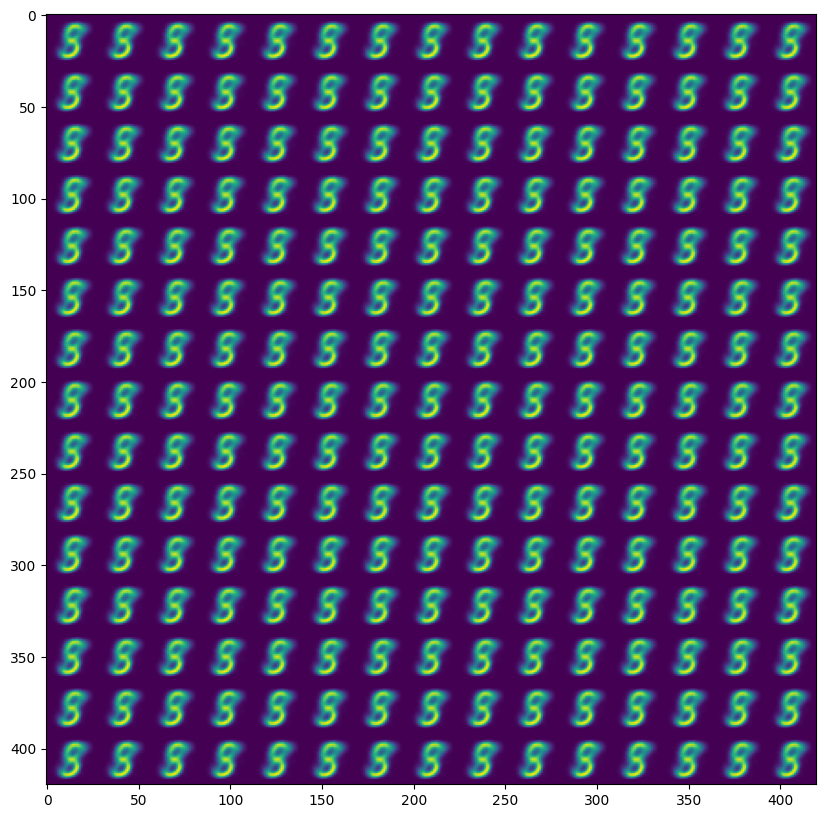

In [104]:
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [98]:
# Estimate latent space from test set
x_encoded_0, _, _ = encoder_0.predict(x_test, batch_size=batch_size_0)

79/79 [==============================] - 2s 20ms/step


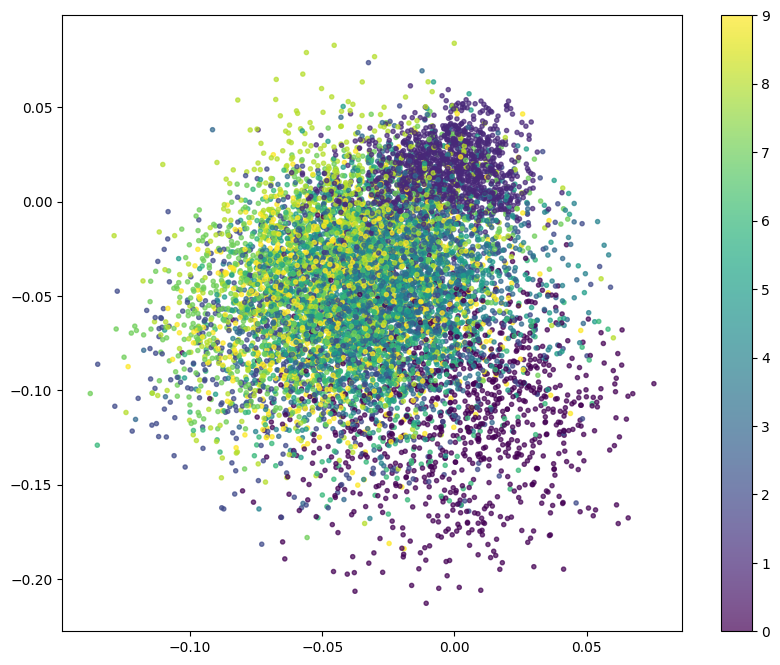

In [99]:
# Show latent space
show_latent_space(x_encoded_0, y_test)

# Discussion


Write down why you design this architecture or why you choose this set of parameter</br>
You should have at least 1 different architectures/set of hyperparameters per person in your team</br>
*Note: For the last step, please turn off a verbose during training

#### **First VAE Architecture**

**Encoder**: This encoder has several convolutional layers to capture hierarchical features from the input images. It uses three 2D convolutional layers followed by a fully connected layer to map the input image to the latent space. The architecture is deeper and more complex, which can capture intricate patterns in the data.

**Variational Parameters**: It includes both the mean and log-variance layers for the latent variables, which are required for VAEs.

**Sampling Layer**: The sampling layer generates the latent variable from the mean and log-variance, following the VAE principle.

**Decoder**: The decoder network uses transposed convolutional layers to map the latent space back to the image space. It's symmetrical to the encoder.

**Custom Loss Function**: The custom loss function is defined using a mean squared error (MSE) reconstruction loss and the Kullback-Leibler (KL) divergence term for regularization.

**Batch Size**: The batch size for training this VAE is set to batch_size, which is equal to 16.

---

####**Second VAE Architecture:**

**Encoder**: This encoder has a simplified architecture compared to the first one. It uses two convolutional layers followed by a fully connected layer to map the input image to the latent space. The architecture is shallower and less complex.

**Variational Parameters**: Similar to the first architecture, it includes both the mean and log-variance layers for the latent variables.

**Sampling Layer**: The sampling layer is the same as in the first architecture.

**Decoder**: The decoder network is simpler and uses fewer transposed convolutional layers.

**Custom Loss Function**: Similar to the first architecture, it defines the custom loss function using an MSE reconstruction loss and KL divergence term.

**Batch Size**: The batch size for training the second VAE is set to batch_size_0, which is equal to 128.

---

####**Reasons for Differences:**

**Complexity**: The first architecture is more complex and deeper, allowing it to capture more intricate patterns in the data. This complexity might be helpful for more challenging datasets with fine-grained features.

**Simplicity**: The second architecture is simpler and has a shallower network. It may be more suitable for datasets with less complexity or for scenarios where faster training and lower memory usage are preferred.

**Loss Reduction**: If the first design is suffering from a high loss, the second design simplifies the network in an attempt to reduce the loss and potentially improve training stability.

**Training Time**: Simpler architectures may train faster, which can be an advantage in some scenarios.
**Batch Size Impact**: It's important to note that the batch size can impact the overall training dynamics and the performance of the VAE.

---

# [Optional] To play further with image generation
You can try variational autoencoder model with the following dataset: </br>
1. Cat & Dog https://www.kaggle.com/c/dogs-vs-cats/data </br>
2. Celebrity image (for those who have high computational power) http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html</br>

### More on Autoencoder Model

Autoencoder tutorial:
1. https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial
2. https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoder

